In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import glob
import cv2
import imageio
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import modules.ShapeNet
import matplotlib.pyplot as plt
import modules.utils
import modules.pytorch_utils
import modules.BackgroundImages

from IPython.display import Image, display

# ShapnetHandler

In [3]:
shapenet_root = "/hdd/mliuzzolino/ShapeNet/data/ShapeNetCore.v2"
shapenet_handler = modules.ShapeNet.Handler(shapenet_root)

In [4]:
imagenet_labels_root = "info/imagenet_class_index.json"
imagenet_idx2label = modules.utils.load_imagenet_labels(imagenet_labels_root)
shapenet_handler.align_with_shapenet(imagenet_idx2label)

# Device

In [5]:
!nvidia-smi

Thu Mar 12 23:53:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 40%   64C    P2    64W / 250W |   6849MiB / 12194MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   35C    P8     9W / 250W |     10MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [6]:
GPU_ON = True
GPU_num = 1
RANDOM_SEED = 42
DEVICE = torch.device(f"cuda:{GPU_num}" if torch.cuda.is_available() and GPU_ON else 'cpu')

# Utils.set_seed(RANDOM_SEED)
print(f"Device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")

Device: cuda:1
Random seed: 42


# Pretrained Model

In [7]:
# Source: https://pytorch.org/docs/stable/torchvision/models.html
resnet18 = models.resnet18(pretrained=True).to(DEVICE)

## Background Images

In [8]:
background_params = {
    "root"               : '/hdd/mliuzzolino/Places2/places365_standard/train',
    "labels_root"        : '/hdd/mliuzzolino/Places2/predicted_labels',
    "eval_model"         : 'resnet18'
}
background = modules.BackgroundImages.BackgroundHandler(**background_params)

Building image paths...
Loading labeled path lookup...


In [9]:
background.list_possible_filter_names()

Counter({'table_lamp': 2667,
         'oxygen_mask': 3425,
         'safe': 3650,
         'boston_bull': 558,
         'barrel': 1363,
         'seashore': 8644,
         'stole': 1497,
         'greenhouse': 10290,
         'cannon': 1384,
         'soccer_ball': 5988,
         'scoreboard': 3796,
         'american_lobster': 1465,
         'dining_table': 8220,
         'pedestal': 5140,
         'refrigerator': 5671,
         'cougar': 524,
         'paddle': 4627,
         'sarong': 1539,
         'military_uniform': 3447,
         'toyshop': 17229,
         'bannister': 10184,
         'water_tower': 4156,
         'bubble': 1914,
         'coral_reef': 2547,
         'car_wheel': 2008,
         'coho': 2056,
         'park_bench': 6580,
         'mountain_tent': 4086,
         'flagpole': 3073,
         'switch': 1572,
         'palace': 15710,
         'throne': 5012,
         'typewriter_keyboard': 675,
         'abacus': 1812,
         'clumber': 152,
         'electric_fan':

In [10]:
classes_specified = ['acoustic_guitar']
background.filter_img_paths_by_class(mode='include', classes_specified=classes_specified)

Original: 1,803,460 -- Final: 976 -- Num Filtered: 1,802,484
Finished setup.


# Dataset Handler

In [20]:
_OUTPUT_ROOT = 'render_output'
_BATCH_SIZE = 64

In [21]:
imagenet_xforms = modules.pytorch_utils.load_imagenet_transformations()

In [22]:
transformations = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    imagenet_xforms['normalize']
])

In [23]:
dataset_params = {
    "root"               : _OUTPUT_ROOT, 
    "background_handler" : background, 
    "background_active"  : True, 
    "mode_key"           : 'generate', # 'generate', 'demo'
    "transforms"         : transformations
}

dataset = modules.ShapeNet.Dataset(**dataset_params)
datahandler = DataLoader(dataset, batch_size=_BATCH_SIZE, shuffle=True)

Building shapenet data filepaths from render_output...
Path setup complete.


### Preview Images

(-0.5, 2065.5, 2065.5, -0.5)

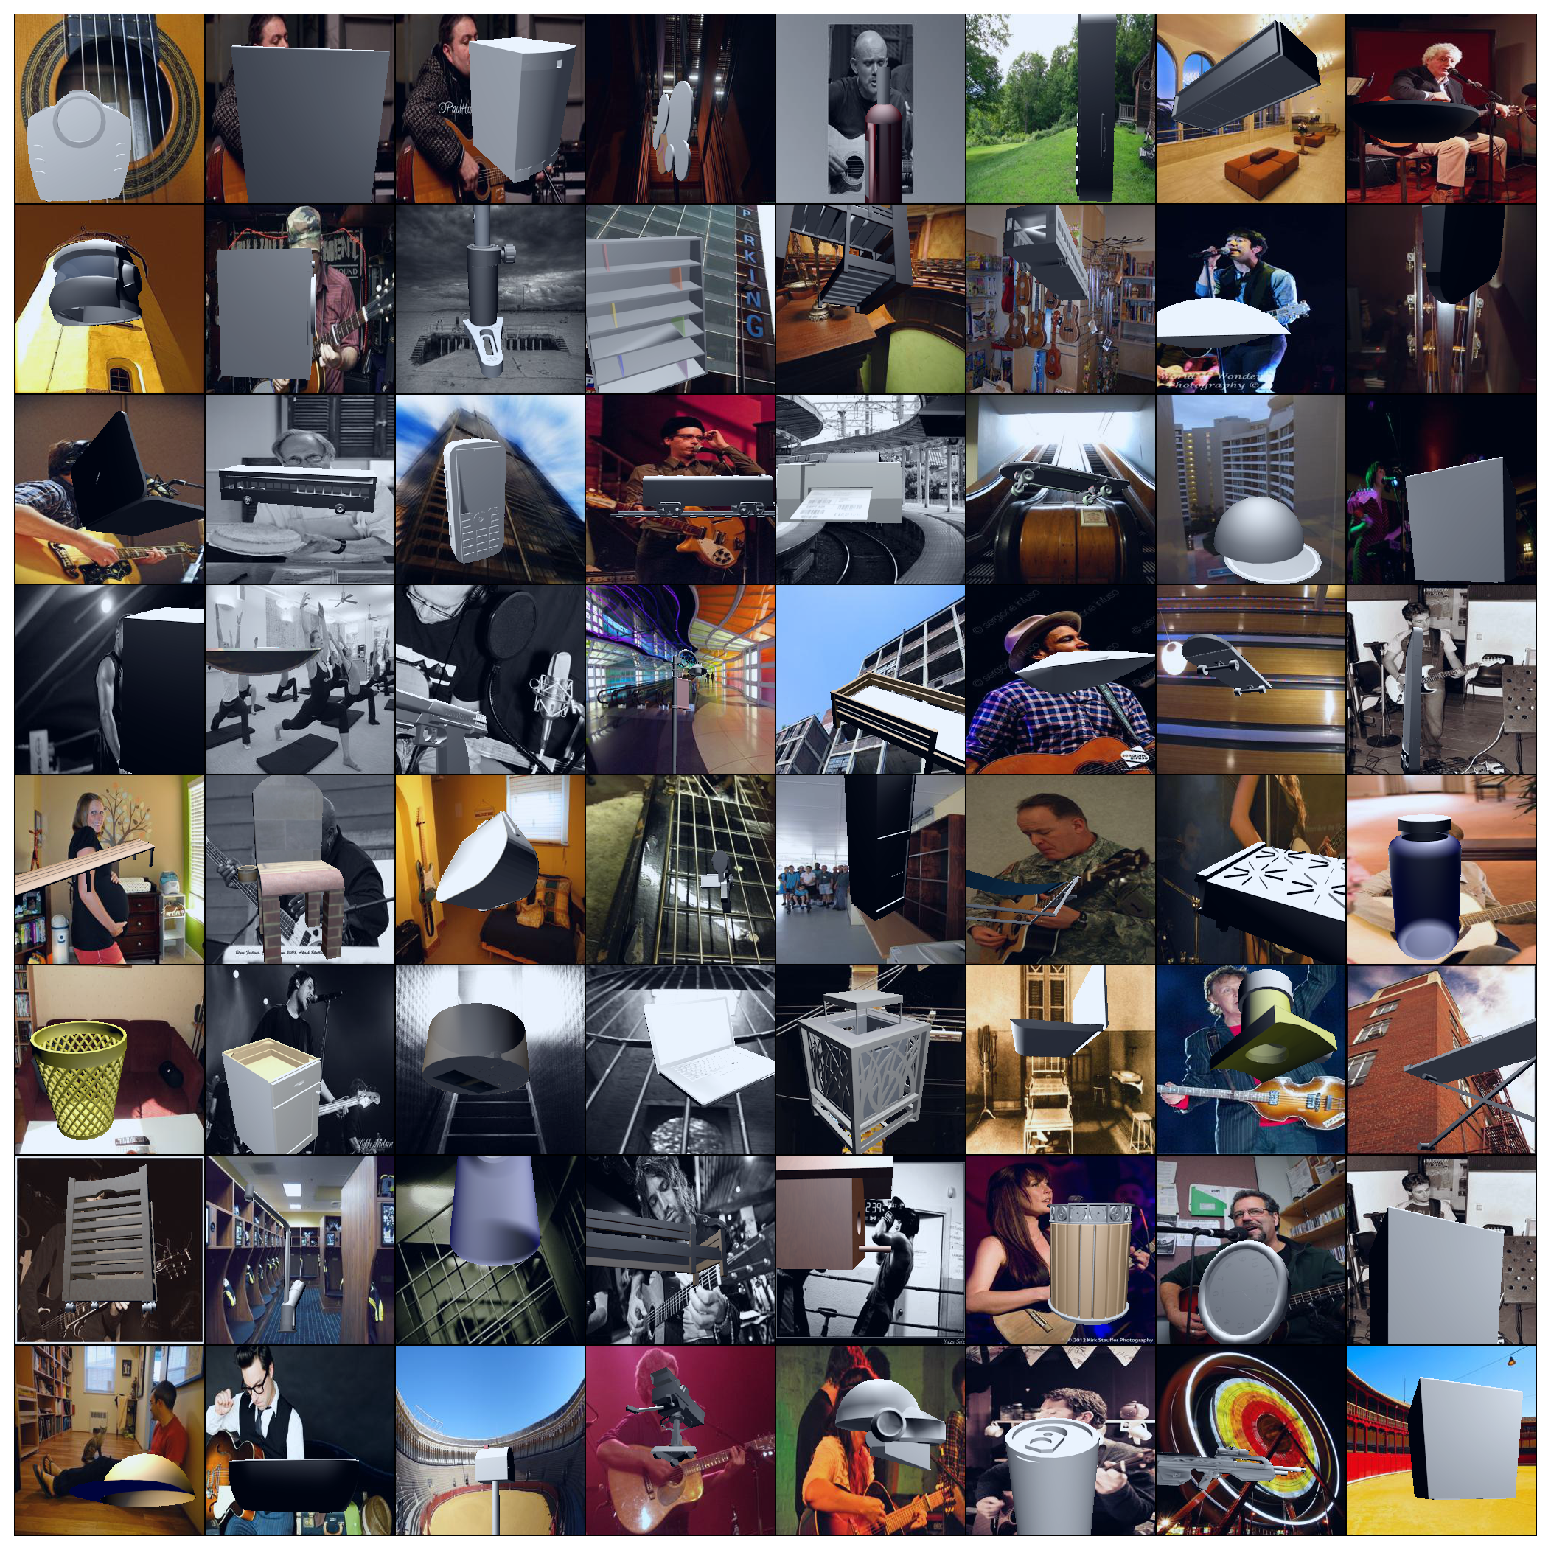

In [24]:
for i, (imgs, class_ids, instance_ids) in enumerate(datahandler):
    break
grid_imgs = torchvision.utils.make_grid(imgs, normalize=True).permute(1,2,0)
plt.figure(figsize=(14,14))
plt.imshow(grid_imgs)
plt.axis('off')

# Evaluate

In [18]:
get_prediction_idxs = lambda out : torch.argmax(nn.Softmax(dim=1)(out), dim=1)

In [19]:
EVAL_BATCH_LIMIT = 10
BAD_MATCH_LABEL = len(imagenet_idx2label)+1

In [ ]:
num_evaluated = 0
all_imgs = []
all_predictions = []
try:
    for i, (imgs, class_ids, instance_ids) in enumerate(datahandler):
        if i > EVAL_BATCH_LIMIT:
            break
        sys.stdout.write(f"\rEvaluating {i+1}/{len(datahandler)}...")
        sys.stdout.flush()

        # Setup labels
        shapenet_names = [shapenet_handler.lookup_name(class_id.item()) for class_id in class_ids]
        actual_labels = np.array([ele[1] for ele in shapenet_names])
        bad_idxs = np.array([i for i, ele in enumerate(actual_labels) if ele is None])
        if len(bad_idxs) > 0:
            actual_labels[bad_idxs] = BAD_MATCH_LABEL
        actual_labels = actual_labels.astype(np.int)
        
        # Send to device
        imgs = imgs.to(DEVICE)

        # Inference
        output = resnet18(imgs)
        predicted_labels = get_prediction_idxs(output).cpu()
        predicted_names = [imagenet_idx2label[pred_idx] for pred_idx in predicted_labels]

        num_correct = (predicted_labels == torch.tensor(actual_labels)).sum()
        num_evaluated += predicted_labels.shape[0]

        if i == 0:
            all_imgs = imgs
            all_predicted_labels = predicted_names
        else:
            all_imgs = torch.cat([all_imgs, imgs], dim=0)
            all_predicted_labels += predicted_names
except KeyboardInterrupt:
    print("\nEnding Early")

In [ ]:
accuracy = (num_correct / float(num_evaluated)).item()
print("accuracy: ", accuracy)

# Visualize

In [ ]:
_VIS_LIMIT = 100
random_idxs = np.random.choice(range(all_imgs.shape[0]), _VIS_LIMIT, replace=False)
for i, idx in enumerate(random_idxs):
    img = all_imgs[idx]
    label = all_predicted_labels[idx]
    if i > _VIS_LIMIT:
        break
    img = (imagenet_xforms['denormalize'](img.clone()) * 255).byte()
    img_np = img.permute(1,2,0).cpu().numpy()
    annotated_im = modules.utils.add_labels_to_img(img_np, label, fontsize=1, x=0, y=50, text_color=[255,0,0])
    annotated_im = annotated_im[np.newaxis,...]
    if i == 0:
        all_annotated_images = annotated_im
    else:
        all_annotated_images = np.concatenate([all_annotated_images, annotated_im], axis=0)

In [ ]:
all_annotated_images_pt = torch.tensor(all_annotated_images).permute(0,3,1,2)
all_annotated_grid = torchvision.utils.make_grid(all_annotated_images_pt, nrow=10).permute(1,2,0)

In [ ]:
plt.figure(figsize=(14,14))
plt.imshow(all_annotated_grid)
plt.axis('off')
plt.savefig('Resnet18_examples.png', dpi=250)